In [7]:
import os
import sys
import logging
import warnings
import pickle
import urllib.request 
import json
import traceback
import datetime
import glob
from pathlib import Path


import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPolygon, Polygon, LineString, MultiLineString, GeometryCollection
from shapely.geometry import box

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..')
sys.path.append(PROJECT_SRC_PATH)

pd.set_option("display.max_columns", None)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s | %(funcName)s - %(message)s', datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)

## Data

In [ ]:
# Convert multi-layer GeoPackage to GeoParquet

# gpk_path = '../data/GHS_UCDB_GLOBE_R2024A.gpkg'
# gdf_list = [gpd.read_file(gpk_path, layer=layer) for layer in fiona.listlayers(gpk_path)]
# gdf_list_wo = gdf_list[:1] + [gdf.drop(columns='geometry') for gdf in gdf_list[1:]]
# urban_areas_2024 = pd.concat(gdf_list_wo, axis=1)
# urban_areas_2024 = urban_areas_2024.loc[:, ~urban_areas_2024.columns.duplicated()]
# urban_areas_2024.to_parquet('../data/GHS_UCDB_GLOBE_R2024A.parquet')

In [ ]:
urban_areas_2019 = gpd.read_parquet('../data/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.parquet')

In [27]:
def compound_annual_growth_rate(start, end, periods):
    return ((end/start)**(1/periods) - 1) * 100


vars_2019 = {
    'ID_HDC_G0': 'GHS_urban_area_id',
    'UC_NM_MN': 'GHS_urban_area',
    'UC_NM_LST': 'GHS_urban_area_cities',
    'CTR_MN_NM': 'GHS_country',
    'GRGN_L1': 'GHS_region',
    'GRGN_L2': 'GHS_subregion',
    'CTR_MN_ISO': 'GHS_country_code',
    'SDG_A2G14': 'GHS_green_access',
    'E_GR_AV14': 'GHS_greeness',
    'P15': 'GHS_population',
    'BUCAP15': 'GHS_built_up_area_pc',
    'SDG_OS15MX': 'GHS_open_spaces',
    'SDG_LUE9015': 'GHS_urban_sprawl',
    'GDP15_SM': 'GHS_total_GDP',
    'E_WR_P_14': 'GHS_rain',
    'E_WR_T_14': 'GHS_temperature',
    'EX_HW_IDX': 'GHS_heatwaves',
    'E_KG_NM_LST': 'GHS_climate_class',
    'EL_AV_ALS': 'GHS_elevation',
    'DEV_CMI': 'UN_development_group',
    'INCM_CMI': 'UN_income_class',
}

urban_areas_2019 = gpd.read_parquet('../data/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.parquet')

urban_areas_2019['GHS_population_growth'] = compound_annual_growth_rate(urban_areas_2019['P00'], urban_areas_2019['P15'], 15)
urban_areas_2019['GHS_GDP_PPP'] = urban_areas_2019['GDP15_SM'] / urban_areas_2019['P15']
urban_areas_2019['GHS_GDP_PPP_growth'] = compound_annual_growth_rate(urban_areas_2019['GDP00_SM'] / urban_areas_2019['P00'], urban_areas_2019['GDP15_SM'] / urban_areas_2019['P15'], 15)
urban_areas_2019['GHS_built_up_area_pc_growth'] = compound_annual_growth_rate(urban_areas_2019['BUCAP00'], urban_areas_2019['BUCAP15'], 15)
urban_areas_2019['GHS_population_density'] = urban_areas_2019['P15'] / urban_areas_2019['B15']
urban_areas_2019['GHS_population_density_growth'] = compound_annual_growth_rate(urban_areas_2019['P00'] / urban_areas_2019['B00'], urban_areas_2019['P15'] / urban_areas_2019['B15'], 15)

aux_cols = ['GHS_urban_area_id', 'GHS_urban_area', 'GHS_country', 'GHS_region', 'geometry']
vars_of_interest = ['GHS_population', 'GHS_population_density', 'GHS_GDP_PPP', 'GHS_built_up_area_pc', 'GHS_population_growth', 'GHS_population_density_growth', 'GHS_GDP_PPP_growth', 'GHS_built_up_area_pc_growth']

urban_areas_2019 = urban_areas_2019.rename(columns=vars_2019)#[vars_of_interest + aux_cols]


In [129]:
vars_2024 = {
    'ID_UC_G0': 'GHS_urban_area_id',
    'GC_UCN_MAI_2025': 'GHS_urban_area',
    'GC_UCN_LIS_2025': 'GHS_urban_area_cities',
    'GC_CNT_GAD_2025': 'GHS_country',
    'GC_DEV_USR_2025': 'GHS_region',
    'SD_LUE_LPR_2000_2020': 'GHS_land_use_efficiency',
    'GH_BPC_TOT_2025': 'GHS_built_up_area_pc',
    'GH_BPC_CAG_2000_2025': 'GHS_built_up_area_pc_growth',
    'GH_POP_TOT_2025': 'GHS_population',
    'GH_POP_CAG_2000_2025': 'GHS_population_growth',
    'GH_POP_DEN_2025': 'GHS_population_density',
    'GH_PD_CAG_2000_2025': 'GHS_population_density_growth',
    'GH_GDP_CAG_2000_2020': 'GHS_GDP_PPP_growth',
    'GC_DEV_WIG_2025': 'GHS_development_group',
    'EX_L05_SHP_2025': 'GHS_flood_exposure',
}

urban_areas_2024 = gpd.read_parquet('../data/GHS_UCDB_GLOBE_R2024A.parquet')

urban_areas_2024['GHS_population_growth'] = compound_annual_growth_rate(urban_areas_2024['GH_POP_TOT_2000'], urban_areas_2024['GH_POP_TOT_2025'], 25)
urban_areas_2024['GHS_GDP_PPP_growth'] = compound_annual_growth_rate(urban_areas_2024['SC_SEC_GDP_2000'], urban_areas_2024['SC_SEC_GDP_2020'], 20)
urban_areas_2024['GHS_built_up_area_pc_growth'] = compound_annual_growth_rate(urban_areas_2024['GH_BPC_TOT_2000'], urban_areas_2024['GH_BPC_TOT_2025'], 25)

urban_areas_2024['GHS_population_density'] = urban_areas_2024['GH_POP_TOT_2025'] / (urban_areas_2024['GH_BUS_TOT_2025'] / 1000 / 1000)
urban_areas_2024['GHS_population_density_2000'] = urban_areas_2024['GH_POP_TOT_2000'] / (urban_areas_2024['GH_BUS_TOT_2000'] / 1000 / 1000)
urban_areas_2024['GHS_population_density_growth'] = compound_annual_growth_rate(urban_areas_2024['GHS_population_density_2000'], urban_areas_2024['GHS_population_density'], 25)

urban_areas_2024['GHS_GDP_PPP'] = urban_areas_2024['SC_SEC_GDP_2020'] * (urban_areas_2024.area / 1e6) / urban_areas_2024['GH_POP_TOT_2025']

urban_areas_2024['SD_LUE_LPR_2000_2020'] = urban_areas_2024['SD_LUE_LPR_2000_2020'].replace({'<-5': '-5', '>5': '5'}).astype(float)
urban_areas_2024['GHS_flood_exposure_cat'] = (urban_areas_2024['EX_L05_SHP_2025'] > 0.05).astype(int)

urban_areas_2024 = urban_areas_2024.rename(columns=vars_2024)[vars_of_interest + aux_cols]

In [111]:
country_continent_mapping = pd.read_csv('../data/GADM_country_continent_mapping.csv')
urban_areas_2024['continent'] = urban_areas_2024['GHS_country'].map(country_continent_mapping.set_index('COUNTRY')['CONTINENT'])

# urban_areas_2024_all = urban_areas_2024.copy()
# urban_areas_2024 = urban_areas_2024[urban_areas_2024['continent'] != 'Oceania']

In [123]:
var_labels = {
    'GHS_country': 'Country',
    'GHS_region': 'Region',
    'GHS_land_use_efficiency': 'Land use efficiency',
    'GHS_built_up_area_pc': 'Built-up area per capita [m2/person]',
    'GHS_built_up_area_pc_growth': 'Built-up area per capita growth',
    'GHS_population': 'Population [people]',
    'GHS_population_growth': 'Population growth',
    'GHS_population_density': 'Population density [people/km2]',
    'GHS_population_density_growth': 'Population density growth',
    'GHS_GDP_PPP': "GDP (PPP) per capita [int'l $]",
    'GHS_GDP_PPP_growth': 'GDP (PPP) per capita growth',
    'GHS_development_group': 'World Bank income group',
    'GHS_flood_exposure': 'Low Elevated Coastal Zone (LECZ)',
}

## Descriptive Analyses

In [11]:
vars_to_plot = ['GHS_population', 'GHS_population_density', 'GHS_GDP_PPP', 'GHS_built_up_area_pc', 'GHS_population_growth', 'GHS_population_density_growth', 'GHS_GDP_PPP_growth', 'GHS_built_up_area_pc_growth']

hue_var = 'continent'
# hue_var = 'GHS_region'
# hue_var = 'GHS_development_group'


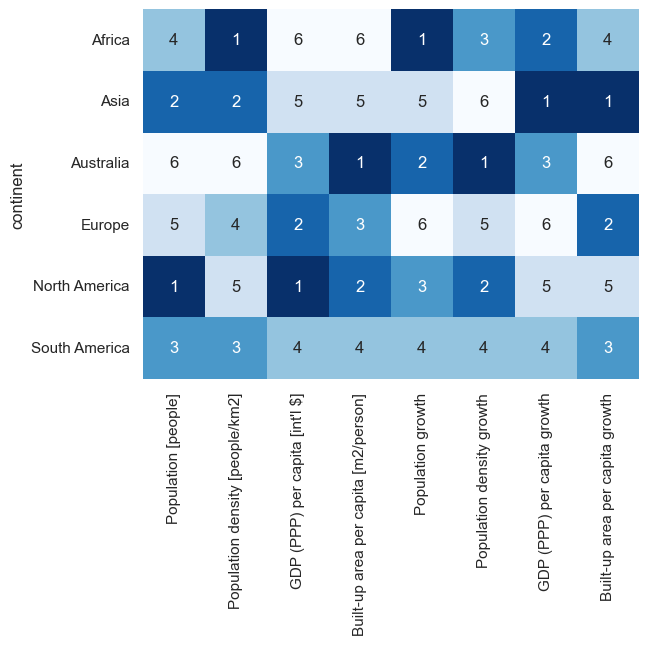

In [ ]:
ranked_regions = urban_areas_2024.groupby('continent')[vars_to_plot].median().rank(ascending=False).rename(columns=var_labels)
ax = sns.heatmap(ranked_regions, annot=True, cmap='Blues_r', fmt='.0f', cbar=False)
highlight_row = 4
# ax.hlines([highlight_row, highlight_row + 1], *ax.get_xlim(), colors='red', linewidth=2)

rect = mpatches.Rectangle(
    (0, highlight_row),   # (x, y)
    width=ranked_regions.shape[1],
    height=1,
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
# ax.add_patch(rect)
plt.show()


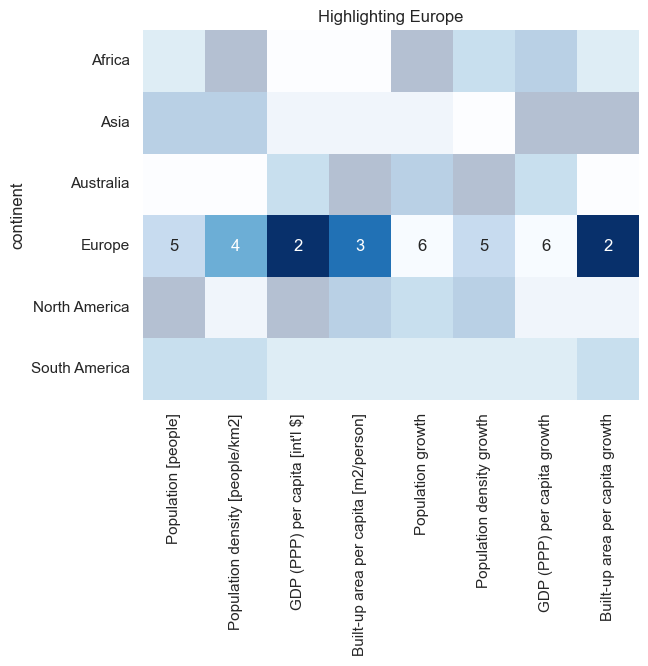

In [635]:
# Your data preparation
ranked_regions = urban_areas_2024.groupby('continent')[vars_to_plot].median().rank(ascending=False).rename(columns=var_labels)

# Choose the row to highlight
highlight_row = 'Europe'

# Create a mask to dim all but the target row
mask = np.ones_like(ranked_regions, dtype=bool)
mask[ranked_regions.index == highlight_row, :] = False  # Keep the highlight row visible

# Plot dimmed heatmap first
sns.heatmap(ranked_regions, mask=~mask, annot=False, cmap='Blues_r', cbar=False, alpha=0.3)

# Overlay the highlighted row (with full opacity)
sns.heatmap(ranked_regions, mask=mask, annot=True, cmap='Blues_r', fmt='.0f', cbar=False)

plt.title(f"Highlighting {highlight_row}")
plt.show()

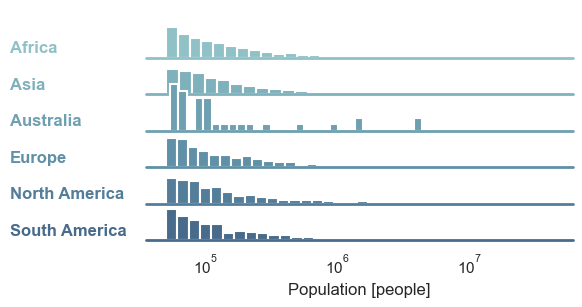

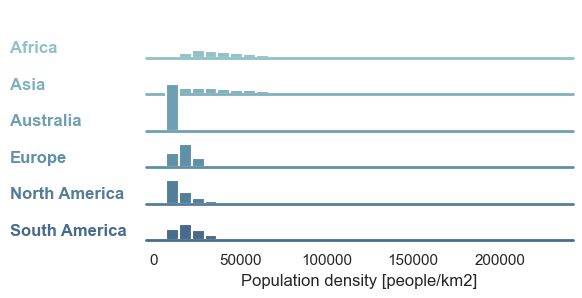

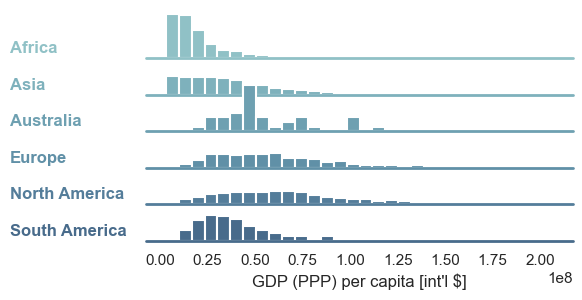

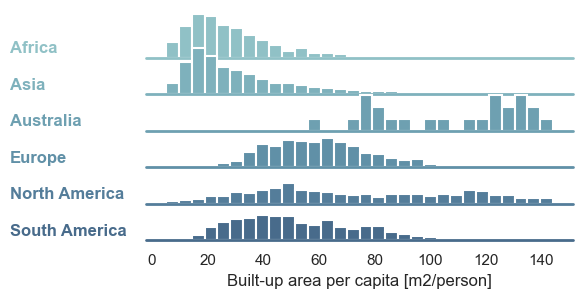

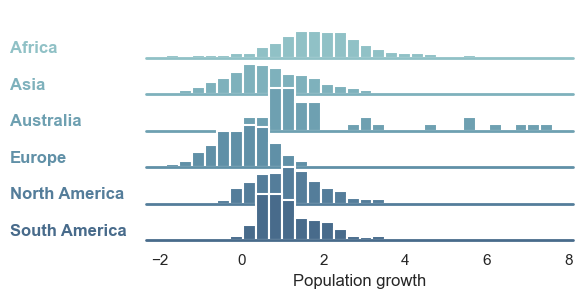

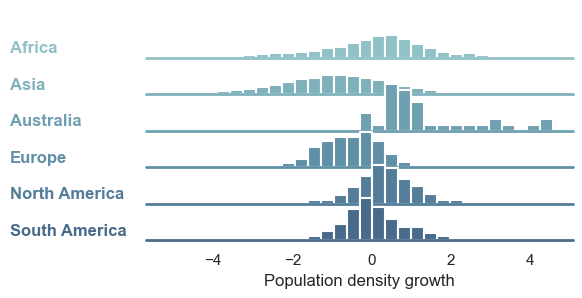

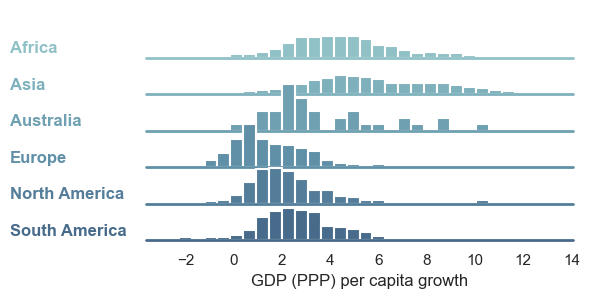

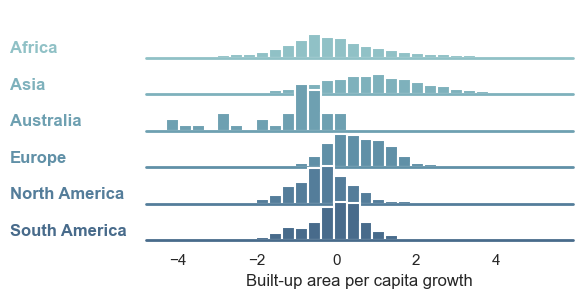

In [ ]:

def ridge_hist(data, hue, var):
      sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
      df = data[data['variable'] == var]
      x = df['value'].dropna()
      lower, upper = np.percentile(x, [1, 99])
      bin_edges = np.histogram_bin_edges(x, bins=30, range=(lower, upper))
      hue_order = df[hue].cat.categories

      # Initialize the FacetGrid object
      pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
      g = sns.FacetGrid(df, row=hue, hue=hue, hue_order=hue_order, aspect=11, height=.5, palette=pal)

      # Draw the densities in a few steps
      if var == 'GHS_population':
            g.map(sns.histplot, "value", stat="density", bins=30, log_scale=True, clip_on=False, fill=True, alpha=1, linewidth=1.5)
      else:
            g.map(sns.histplot, "value", bins=bin_edges, stat="density", clip_on=False, fill=True, alpha=1, linewidth=1.5)
      # g.map(sns.histplot, "value", bins=bin_edges, stat="probability", clip_on=False, color="w", lw=2)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(-0.32, .2, label, fontweight="bold", color=color,
                        ha="left", va="center", transform=ax.transAxes)


      g.map(label, "value")

      if var == 'GHS_population':
            for ax in g.axes.flat:
                  ax.set_xscale("log")
          
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set_xlabels(var_labels[var])
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

vars_to_plot = ['GHS_population', 'GHS_population_density', 'GHS_GDP_PPP', 'GHS_built_up_area_pc', 'GHS_population_growth', 'GHS_population_density_growth', 'GHS_GDP_PPP_growth', 'GHS_built_up_area_pc_growth']

hue_var = 'continent'
# hue_var = 'GHS_region'
# hue_var = 'GHS_development_group'

df_long = pd.melt(urban_areas_2024, id_vars=['GHS_urban_area_id', hue_var], value_vars=vars_to_plot)

hue_order = ['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'South America']
cat_type = CategoricalDtype(categories=hue_order, ordered=True)
df_long[hue_var] = df_long[hue_var].astype(cat_type)

with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=UserWarning)

      for v in vars_to_plot:
            ridge_hist(df_long, hue_var, v)
            plt.show()

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/si

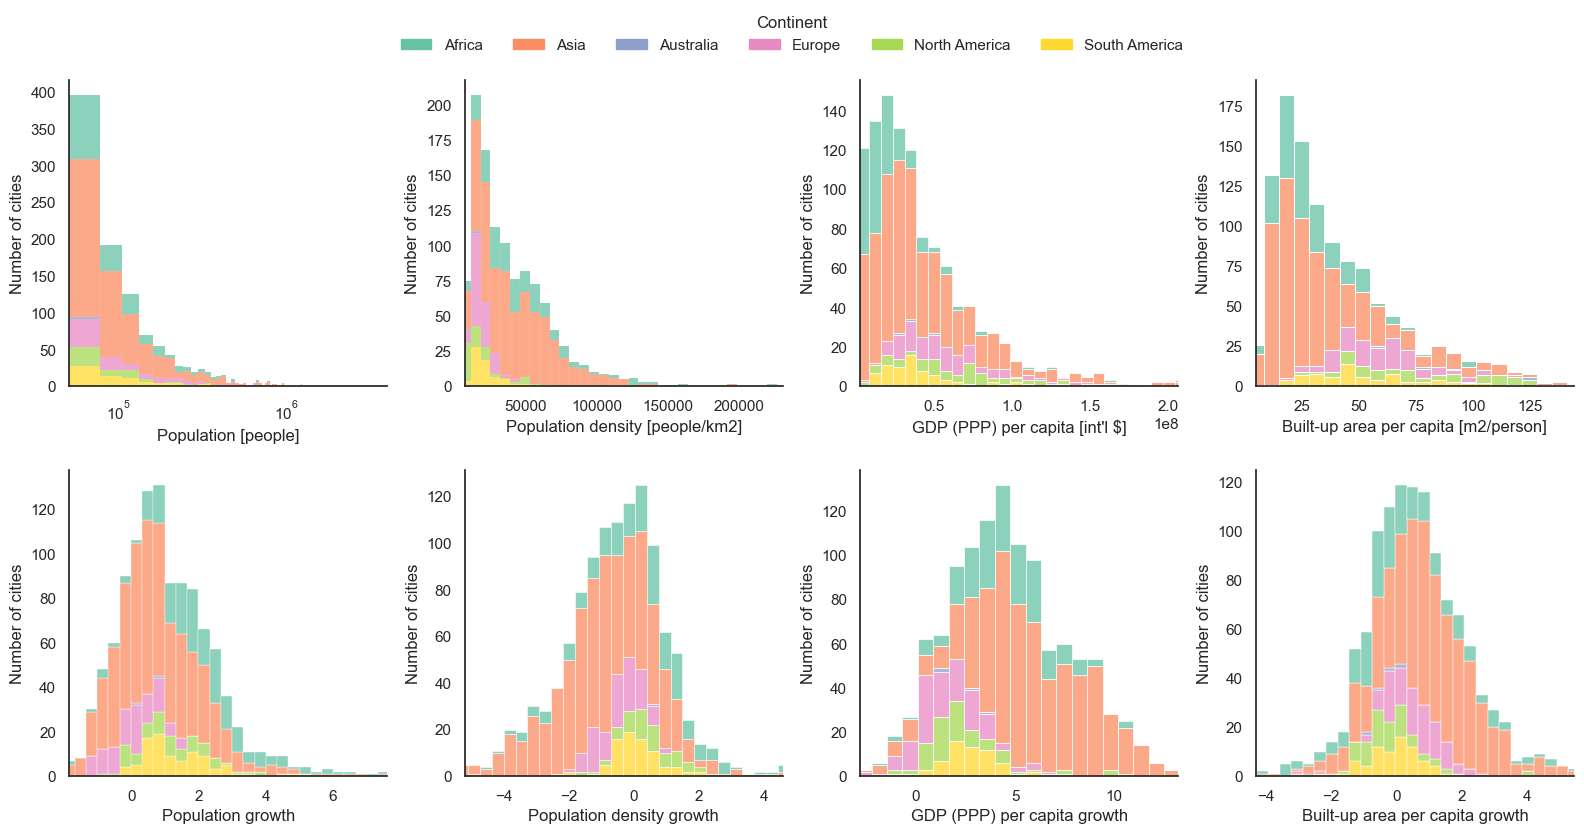

In [ ]:
vars_to_plot = ['GHS_population', 'GHS_population_density', 'GHS_GDP_PPP', 'GHS_built_up_area_pc', 'GHS_population_growth', 'GHS_population_density_growth', 'GHS_GDP_PPP_growth', 'GHS_built_up_area_pc_growth',]

# hue_var = 'GHS_development_group'
# hue_order = ['High income', 'Upper Middle', 'Lower Middle', 'Low income']
hue_var = 'continent'
hue_order = ['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'South America']
df_long = pd.melt(urban_areas_2024, id_vars=['GHS_urban_area_id', hue_var], value_vars=vars_to_plot)

cat_type = CategoricalDtype(categories=hue_order, ordered=True)
df_long[hue_var] = df_long[hue_var].astype(cat_type)

cat_type = CategoricalDtype(categories=vars_to_plot, ordered=True)
df_long['variable'] = df_long['variable'].astype(cat_type)

palette = sns.color_palette('Set2')
g = sns.FacetGrid(df_long.sample(frac=.1).sort_values(['variable', hue_var]), col="variable", hue_order=hue_order, sharex=False, sharey=False, col_wrap=4, height=4)
g.map_dataframe(sns.histplot, "value", hue=hue_var, multiple='stack', palette=palette)


for ax, (var, subdata) in zip(g.axes.flat, df_long.groupby("variable")):
    ax.set_title("")
    ax.set_xlabel(var_labels[var])
    ax.set_ylabel('Number of cities')
    p5, p95 = np.percentile(subdata["value"].dropna(), [1, 99])
    ax.set_xlim(p5, p95)

    if var == "GHS_population":
        ax.set_xscale("log")


# Create custom legend
patches = [mpatches.Patch(color=palette[i], label=hue_order[i]) for i in range(len(hue_order))]
g.fig.legend(
    handles=patches,
    # title="UN Development Group",
    title="Continent",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(hue_order),
    frameon=False
)

# g.add_legend()
plt.show()


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


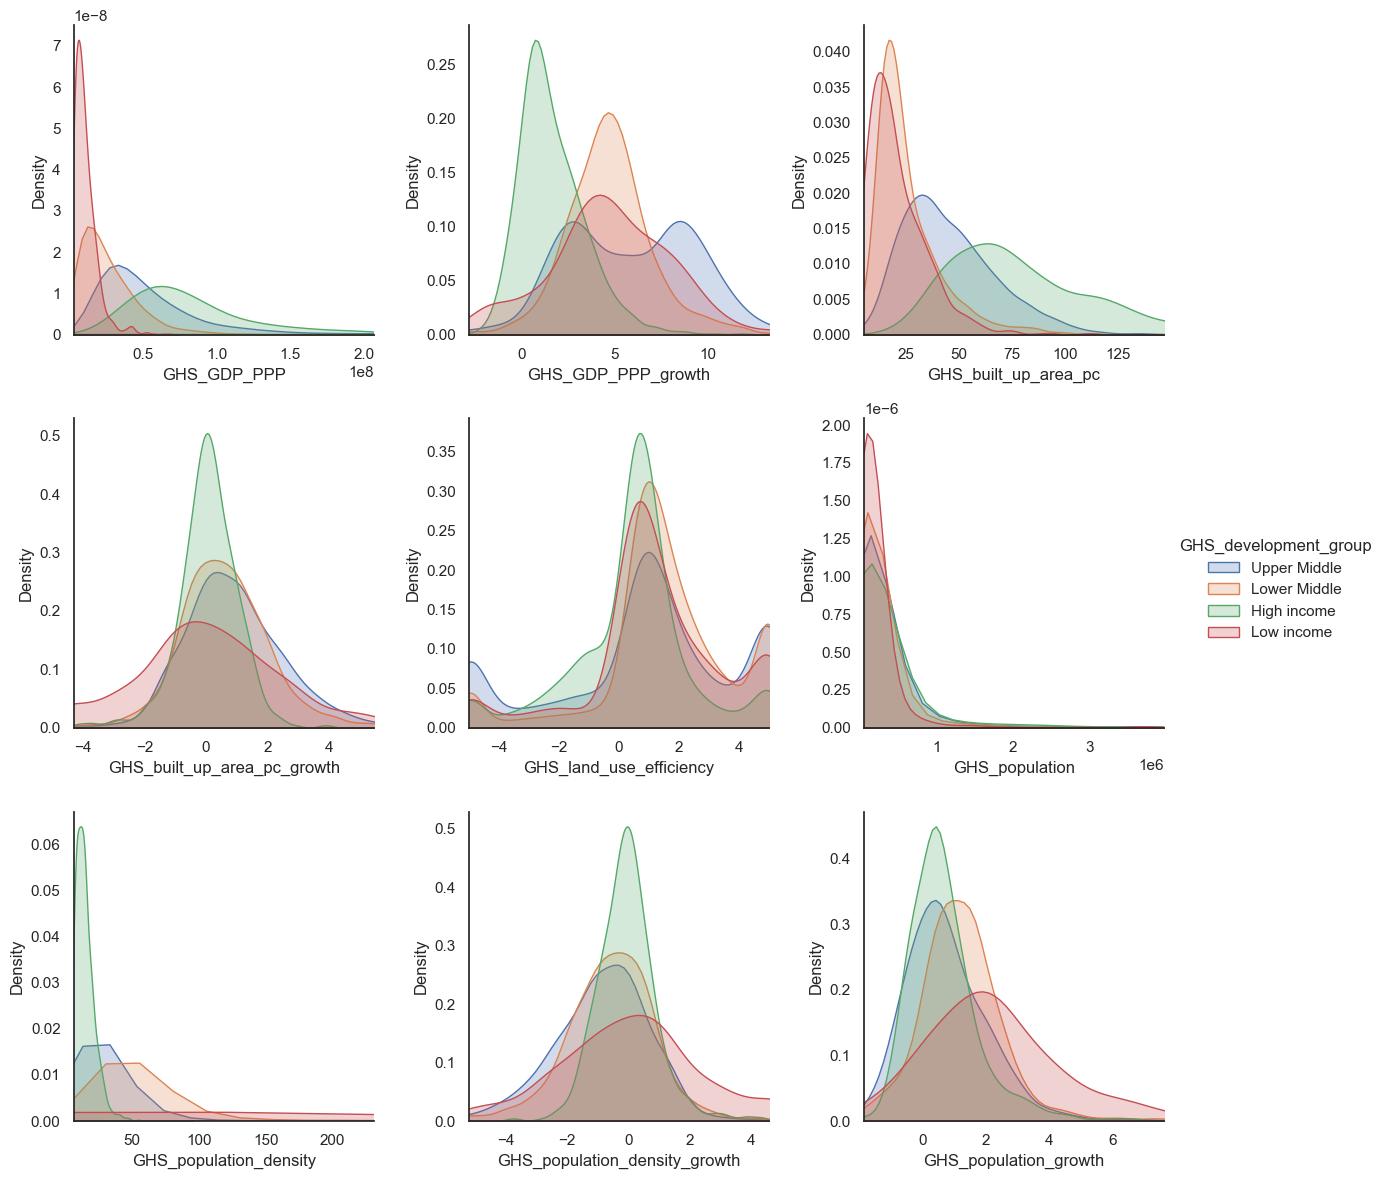

In [ ]:
vars_to_plot = ['GHS_land_use_efficiency', 'GHS_built_up_area_pc', 'GHS_built_up_area_pc_growth', 'GHS_population', 'GHS_population_growth', 'GHS_population_density', 'GHS_population_density_growth', 'GHS_GDP_PPP', 'GHS_GDP_PPP_growth']
hue_var = 'GHS_region'
hue_var = 'GHS_development_group'
hue_order = ['High income', 'Upper Middle', 'Lower Middle', 'Low income']

df_long = pd.melt(urban_areas_2024, id_vars=['GHS_urban_area_id', hue_var], value_vars=vars_to_plot).sort_values('variable')
g = sns.FacetGrid(df_long, col="variable", hue=hue_var, hue_order=hue_order.reverse(), sharex=False, sharey=False, col_wrap=3, height=4)
g.map(sns.kdeplot, "value", fill=True)
g.add_legend()

for ax, (var, subdata) in zip(g.axes.flat, df_long.groupby("variable")):
    p5, p95 = np.percentile(subdata["value"].dropna(), [1, 99])
    ax.set_xlim(p5, p95)
    ax.set_xlabel(var_labels[var])
    ax.set_title("")


plt.show()


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


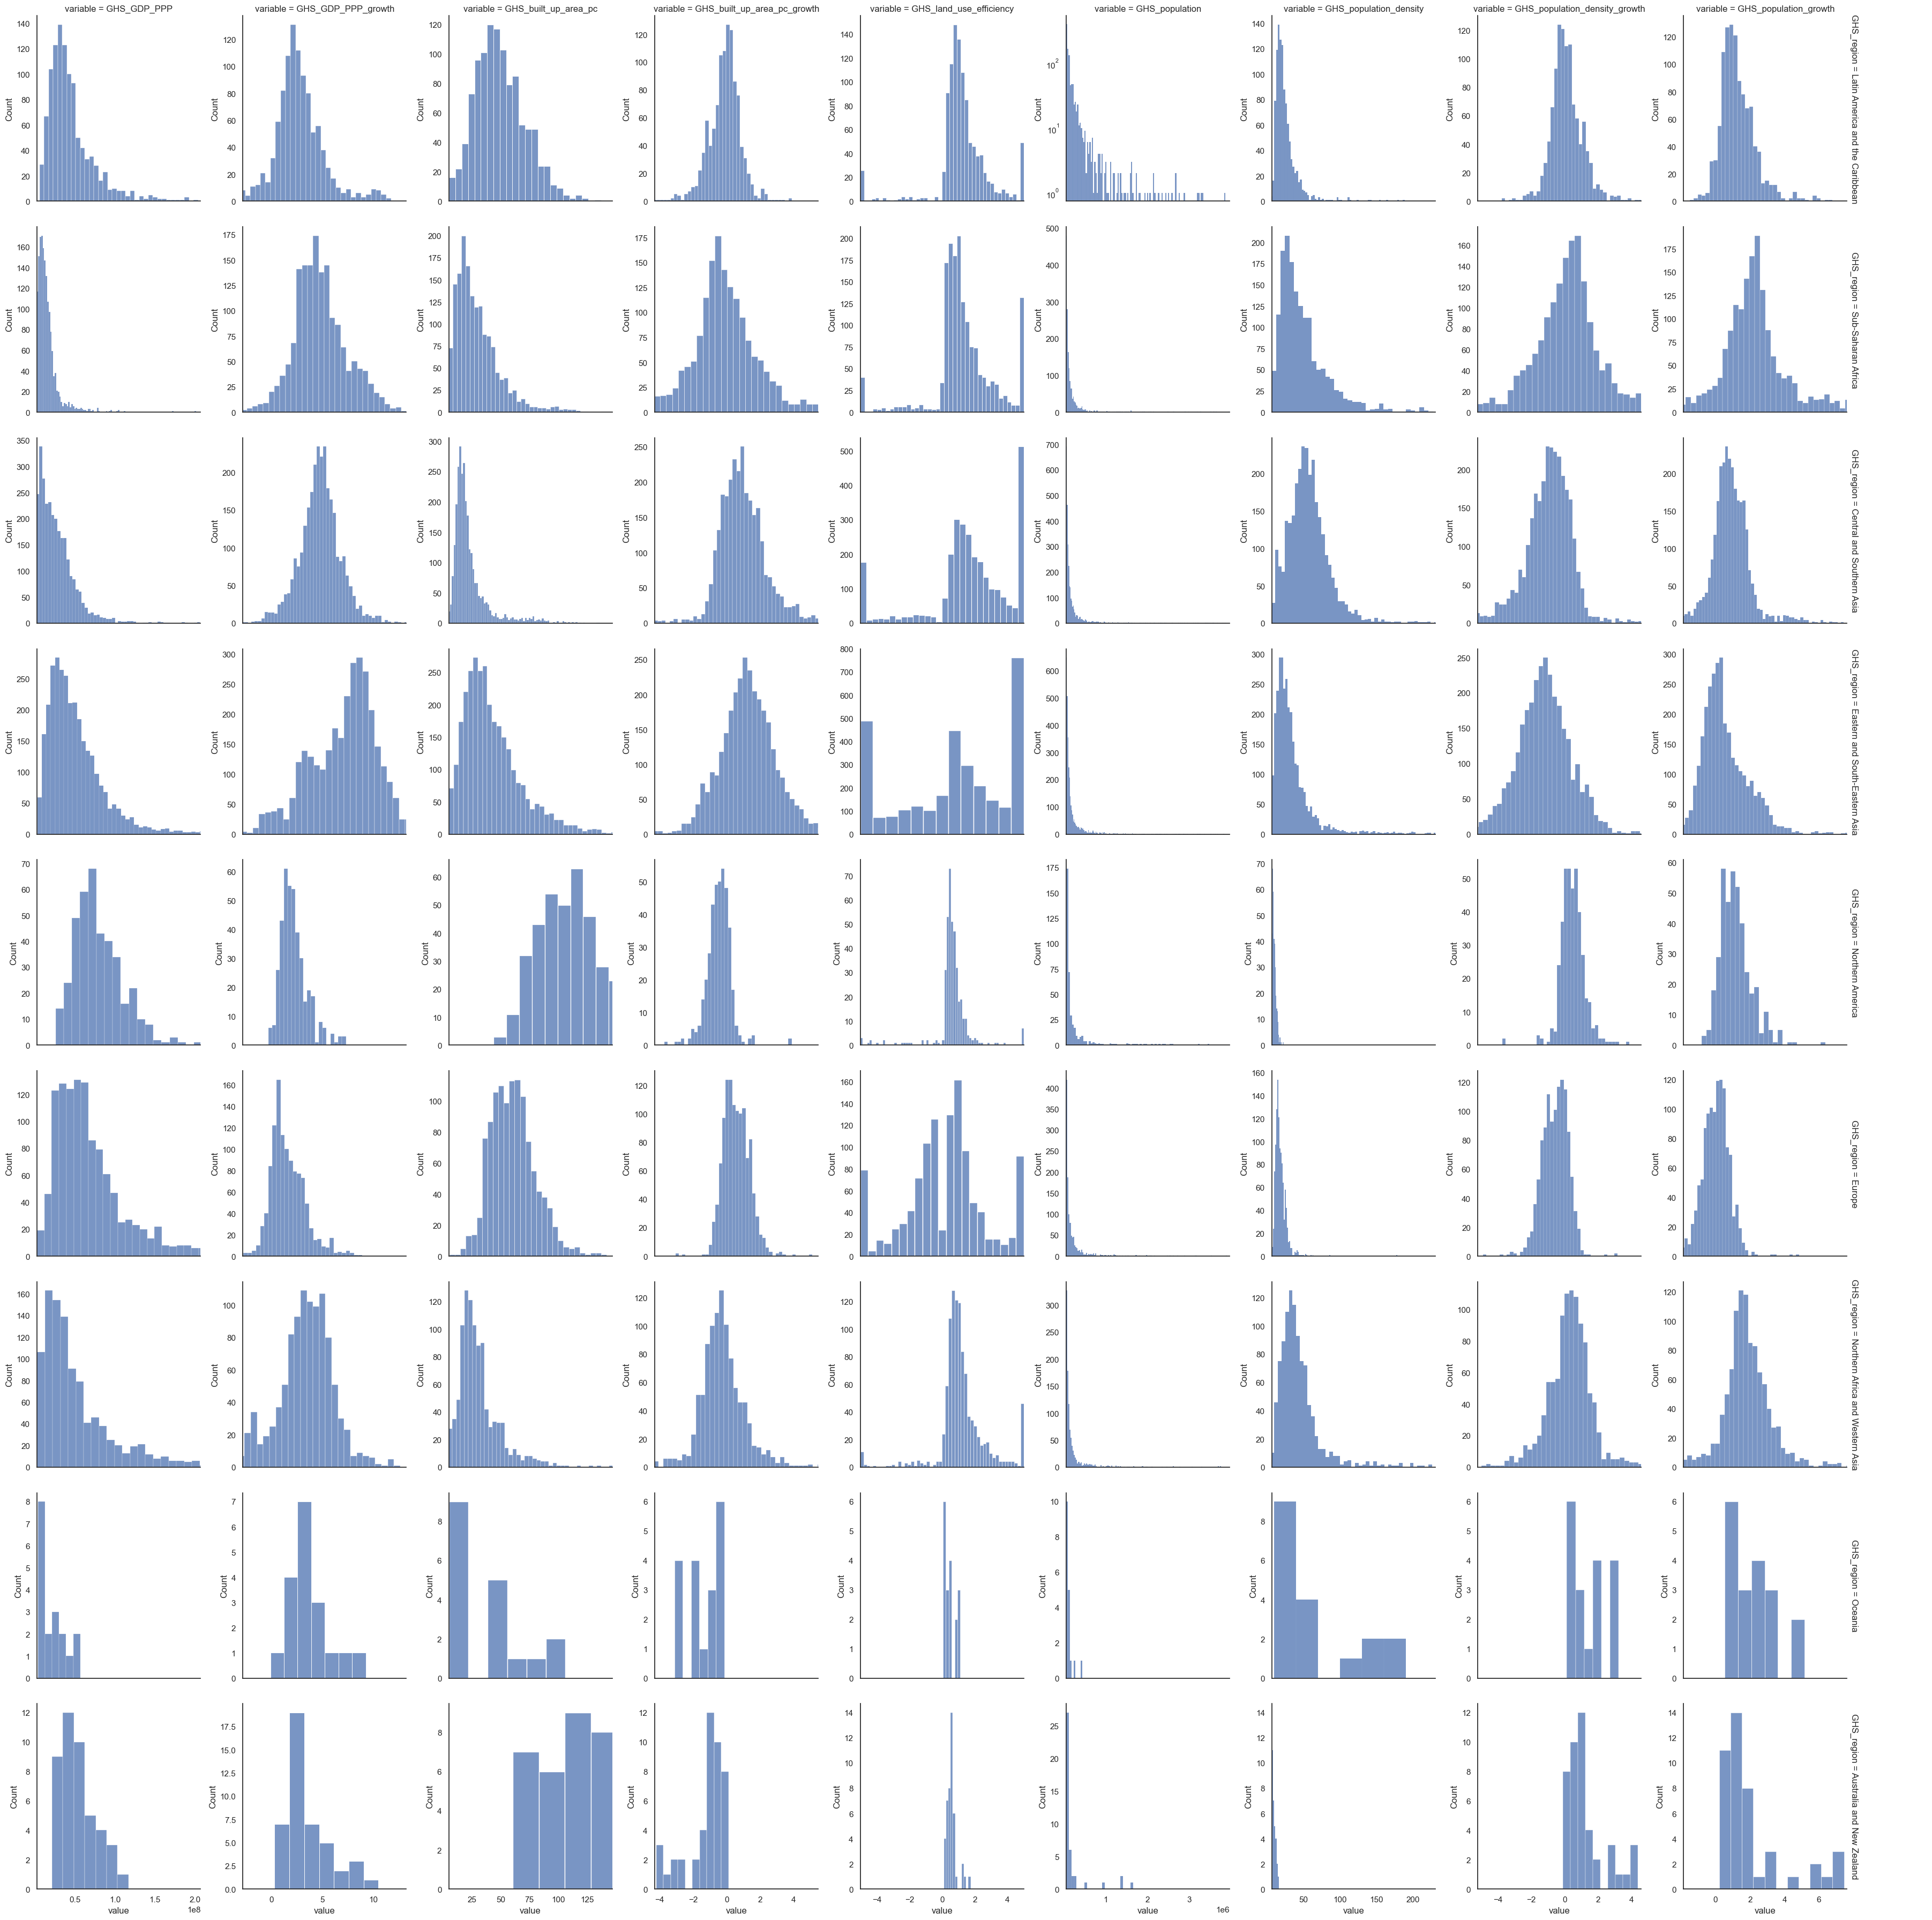

In [588]:
hue_var = 'GHS_region'
df_long = pd.melt(urban_areas_2024, id_vars=['GHS_urban_area_id', hue_var], value_vars=vars_to_plot).sort_values('variable')
g = sns.FacetGrid(df_long, row=hue_var, col="variable", sharex='col', sharey=False, height=4, margin_titles=True)
g.map(sns.histplot, "value")
g.add_legend()

for ax, (var, subdata) in zip(g.axes.flat, df_long.groupby("variable")):
    p5, p95 = np.percentile(subdata["value"].dropna(), [1, 99])
    ax.set_xlim(p5, p95)

    if var == "GHS_population":
        ax.set_yscale("log")

plt.show()

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


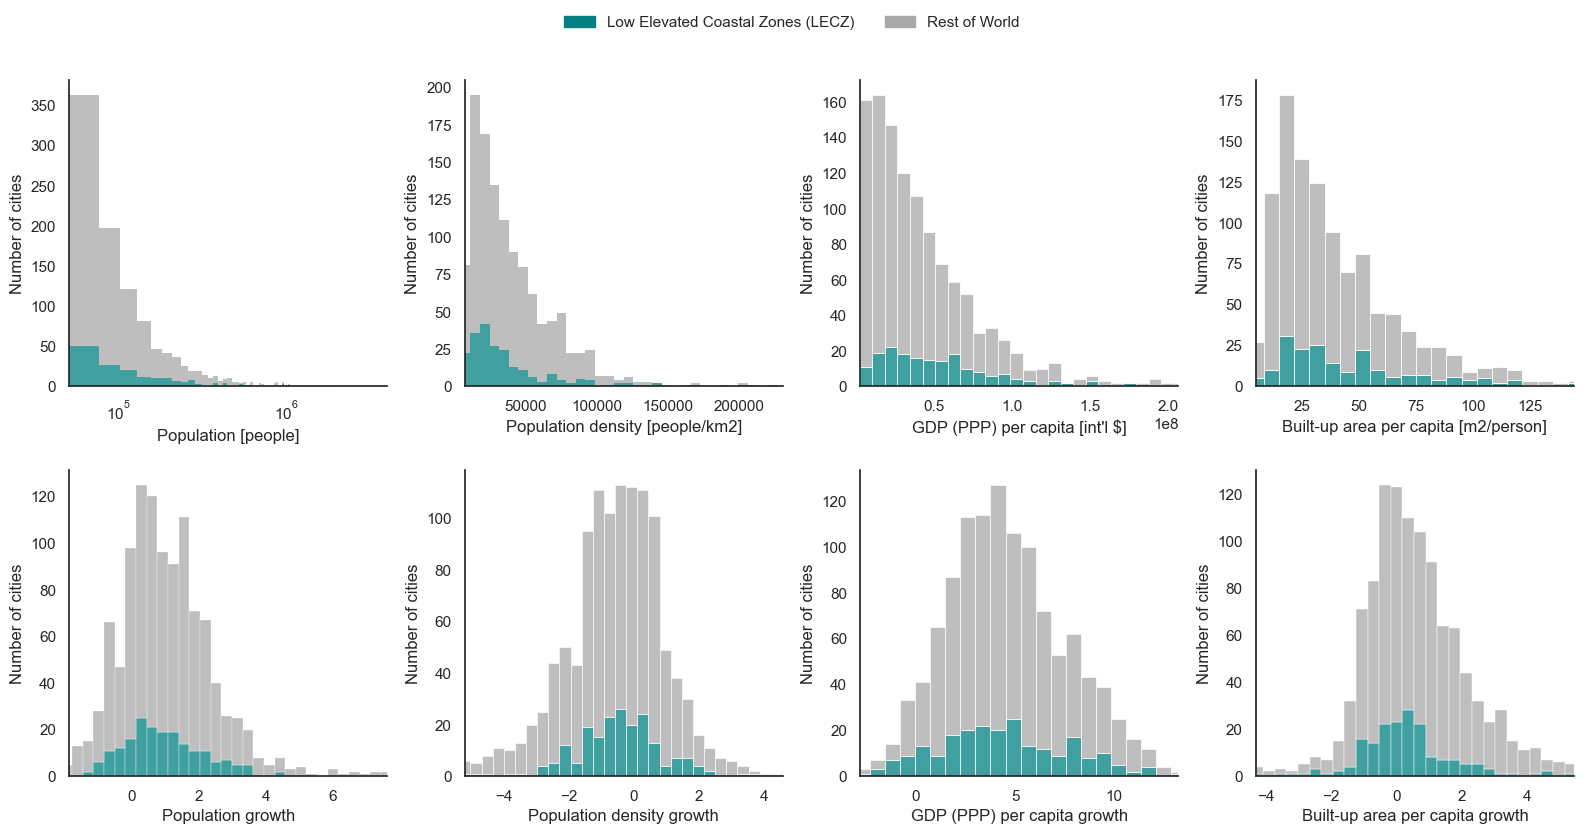

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


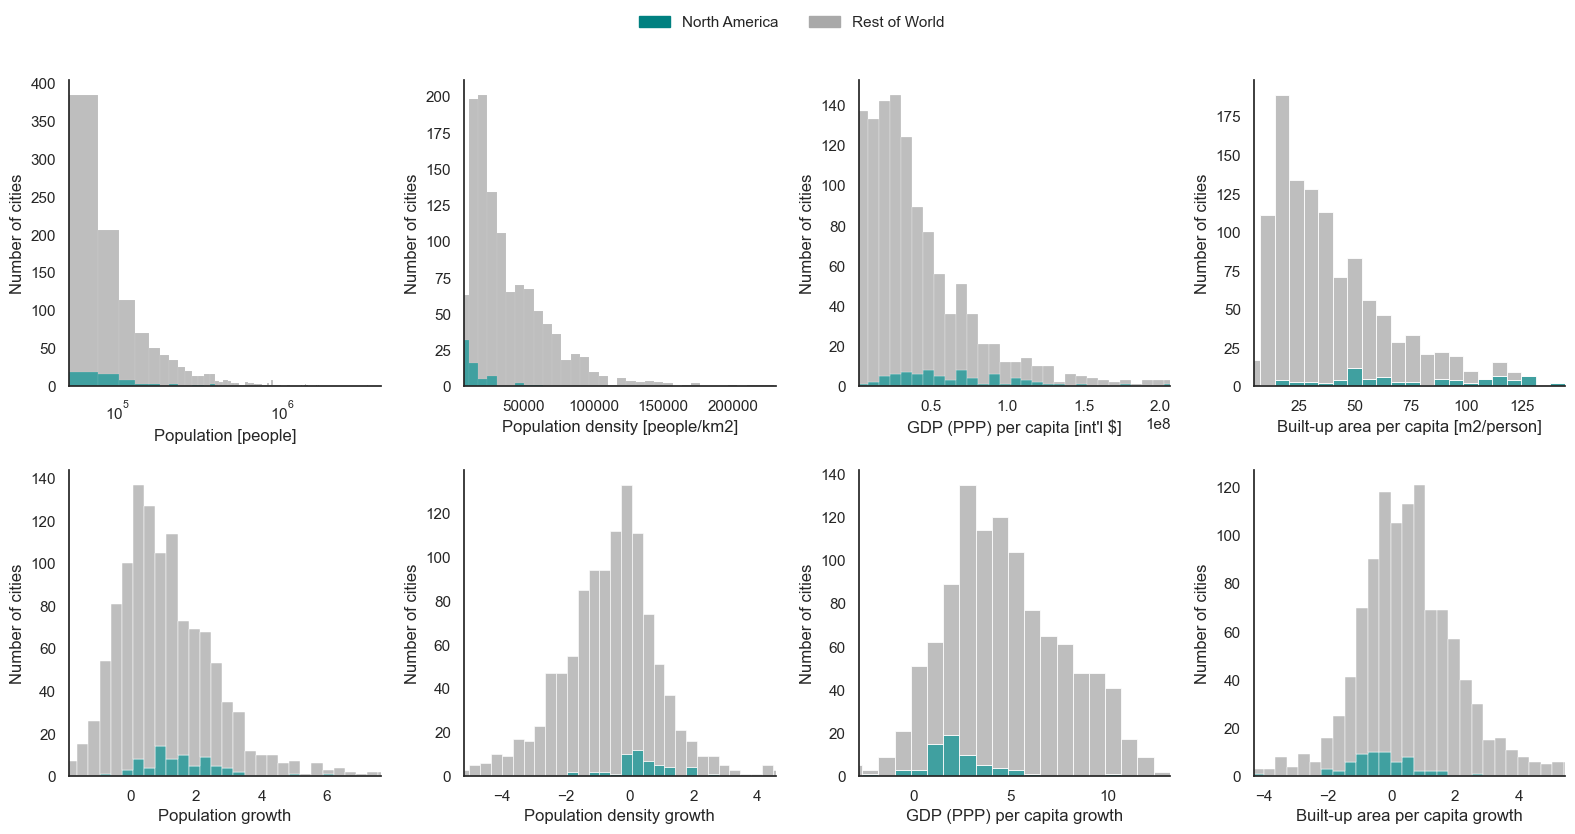

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


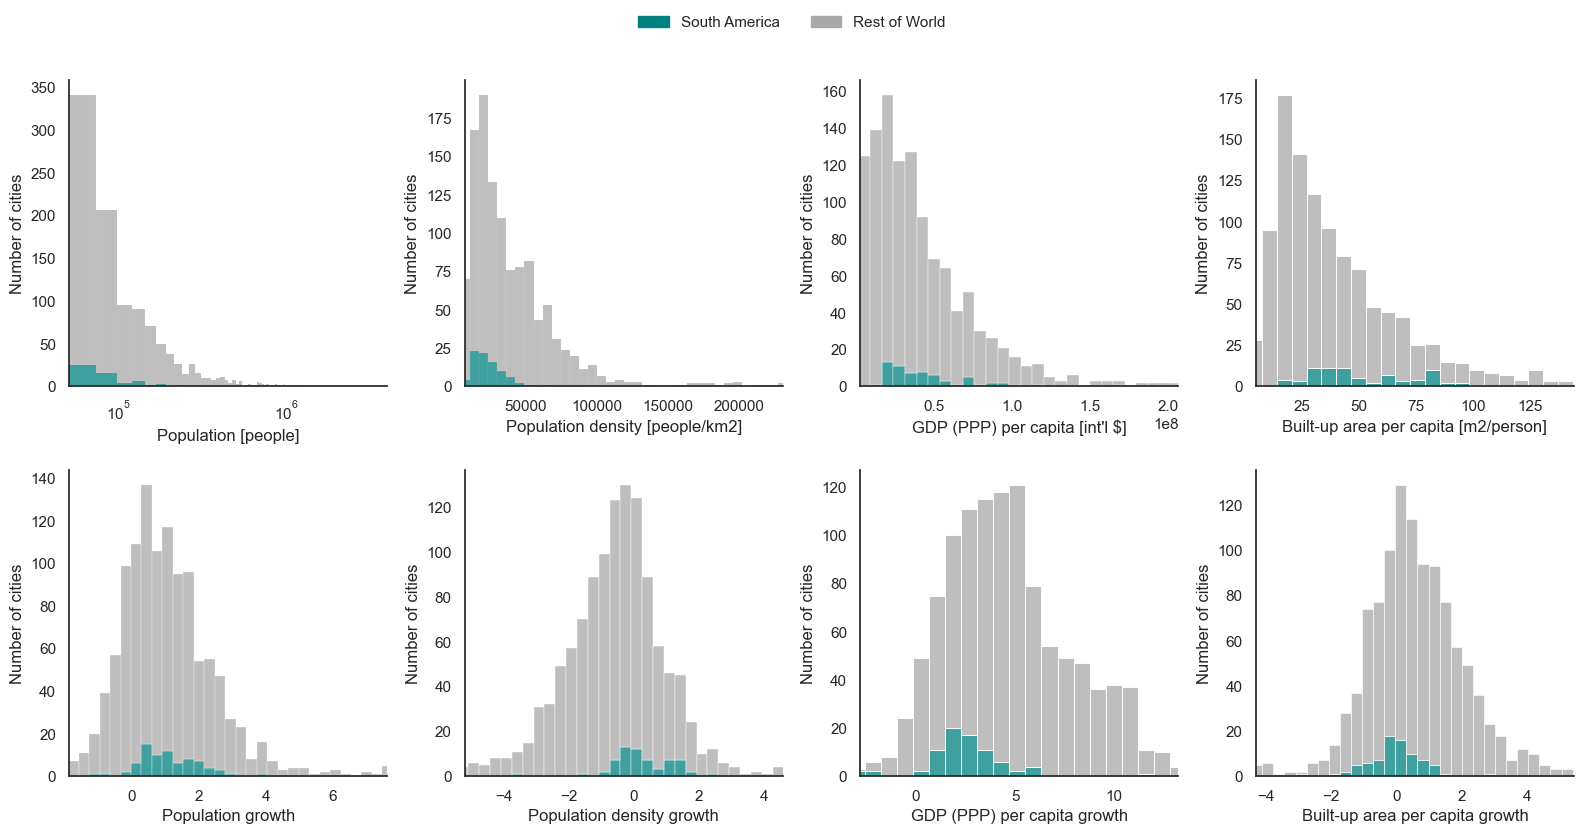

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


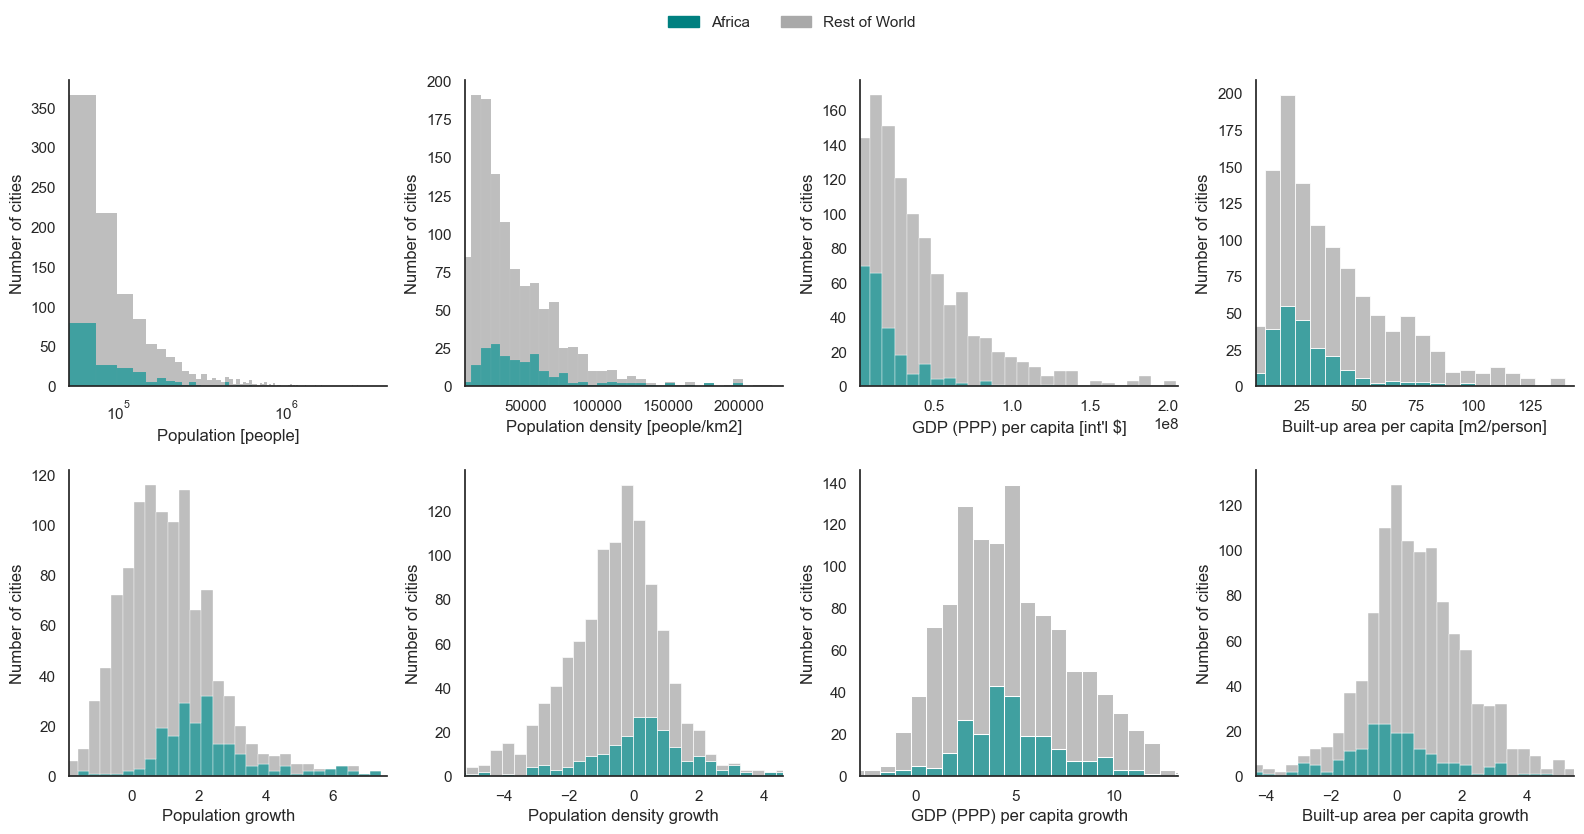

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


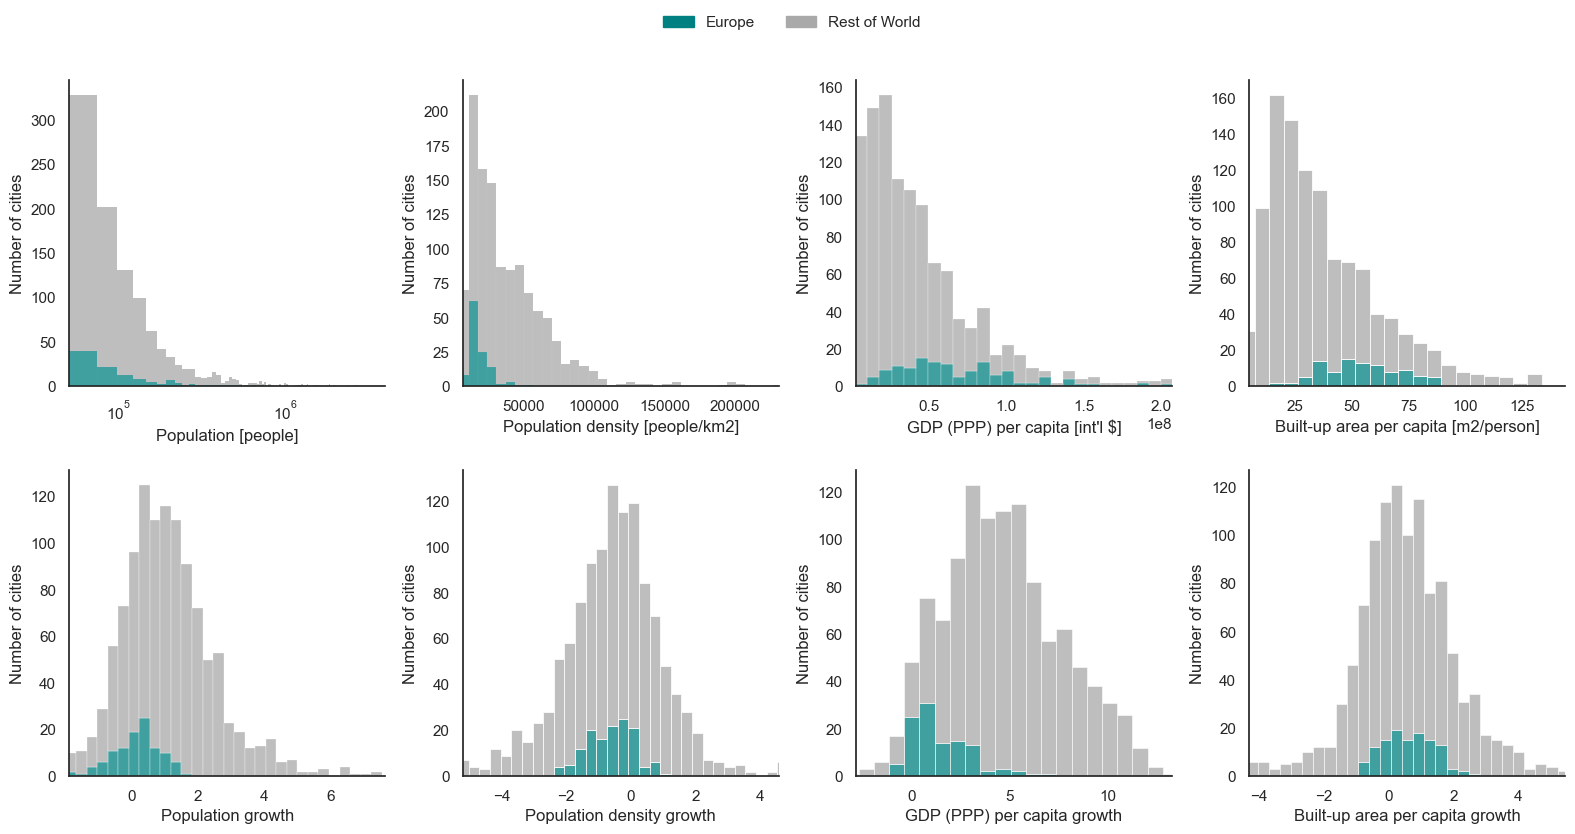

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


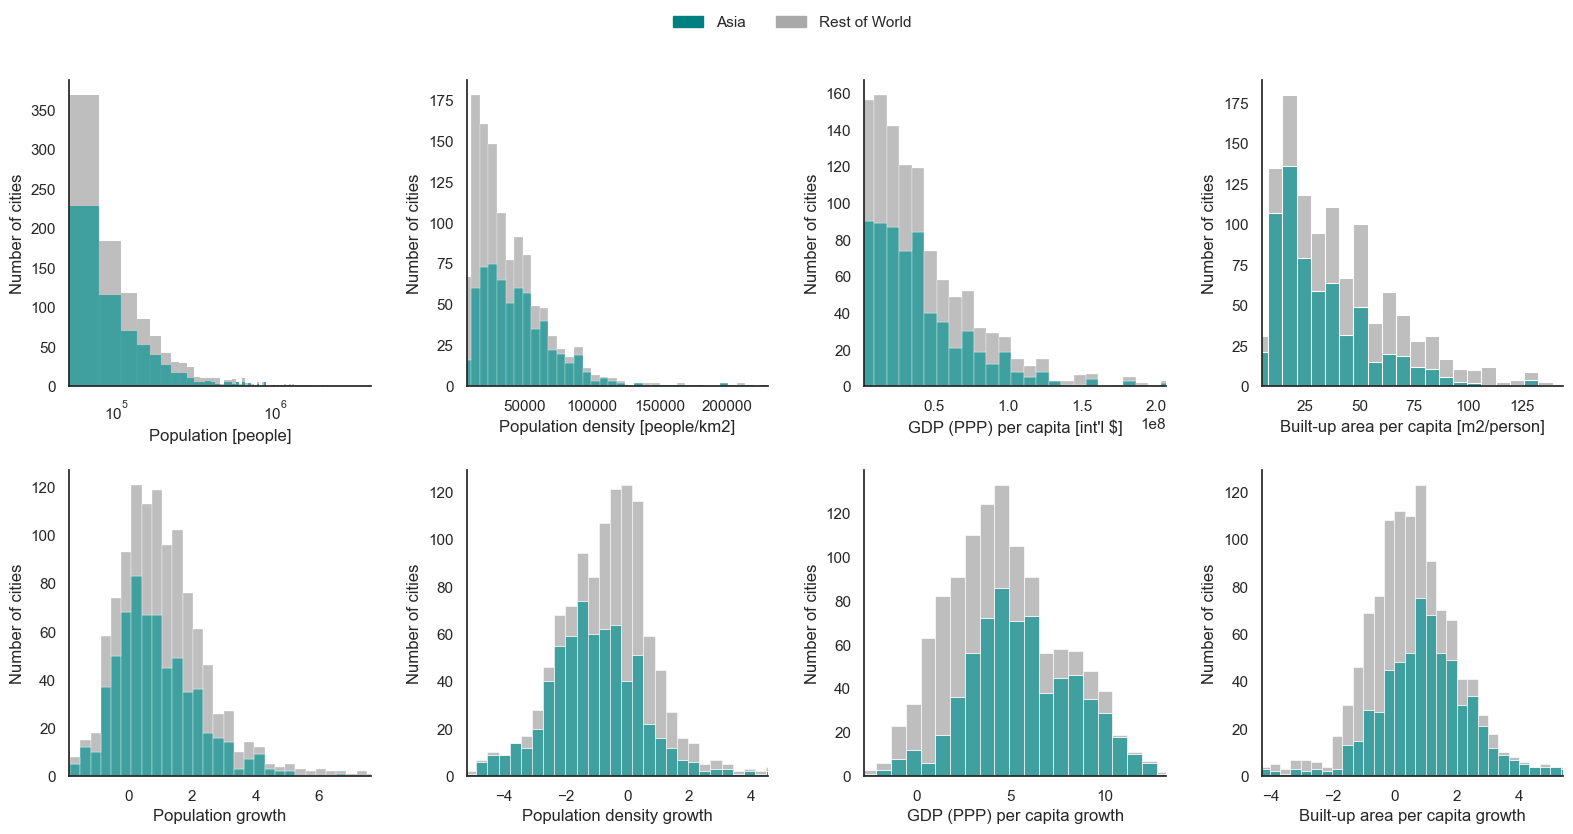

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


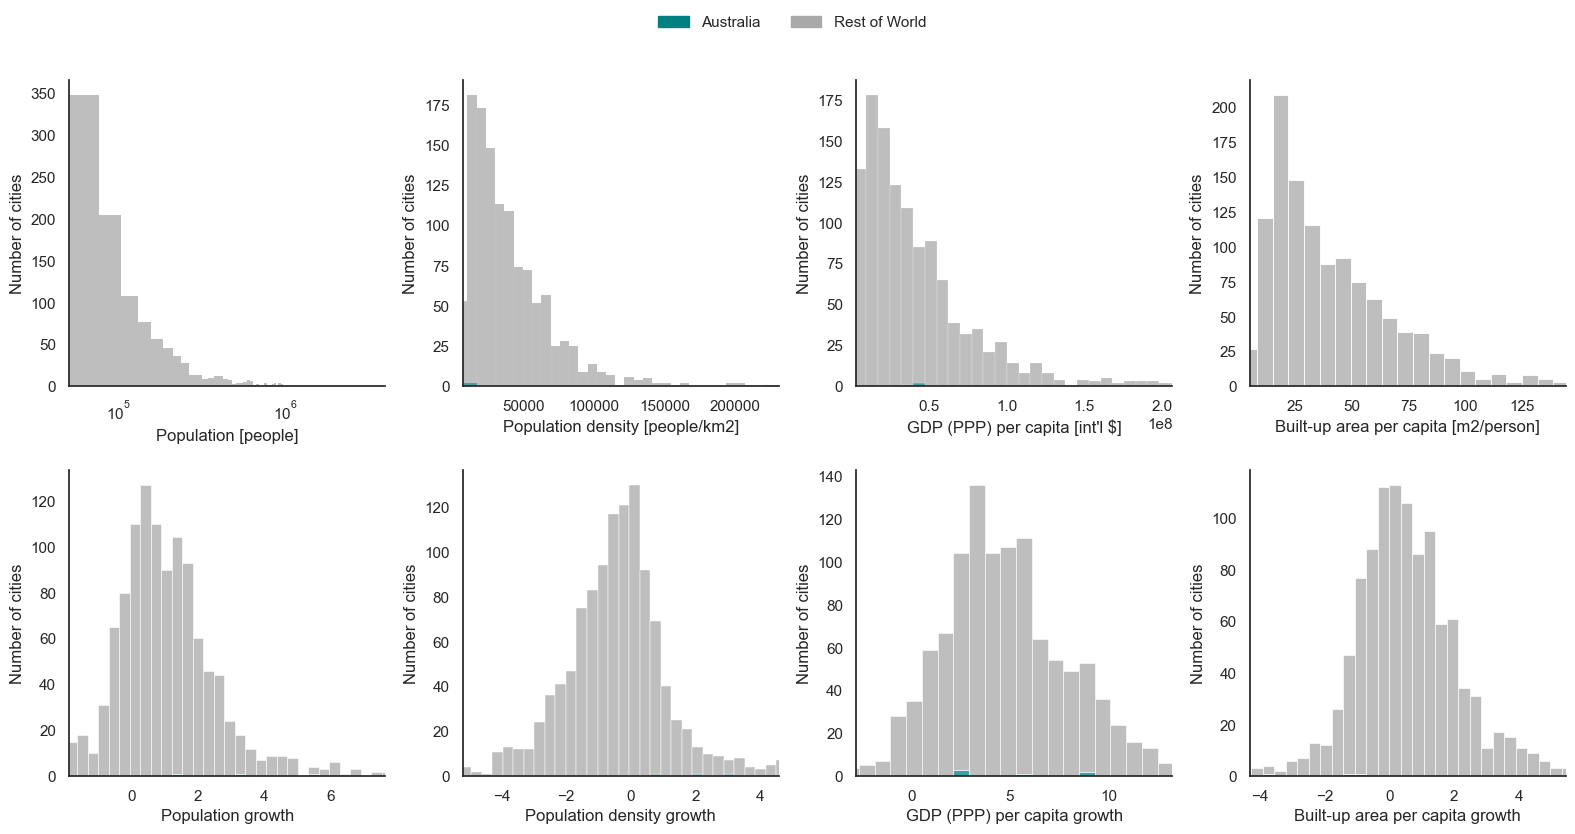

In [ ]:

vars_to_plot = ['GHS_population', 'GHS_population_density', 'GHS_GDP_PPP', 'GHS_built_up_area_pc', 'GHS_population_growth', 'GHS_population_density_growth', 'GHS_GDP_PPP_growth', 'GHS_built_up_area_pc_growth']
# hue_var = 'GHS_region'
hue_var = 'continent'
df_long = pd.melt(urban_areas_2024, id_vars=['GHS_urban_area_id', 'GHS_flood_exposure_cat', hue_var], value_vars=vars_to_plot)
cat_type = CategoricalDtype(categories=vars_to_plot, ordered=True)
df_long['variable'] = df_long['variable'].astype(cat_type)

regions = df_long[hue_var].unique()
df_long = pd.get_dummies(df_long, columns=[hue_var])


df_long = df_long.rename(columns={'GHS_flood_exposure_cat': f'{hue_var}_Low Elevated Coastal Zones (LECZ)'})
colors = ['darkgrey', 'teal']
for region in ['Low Elevated Coastal Zones (LECZ)'] + list(regions):
    region_col = f'{hue_var}_{region}'
    g = sns.FacetGrid(df_long.sample(frac=0.1).sort_values(['variable', region_col], ascending=[True, True]), col="variable", sharex=False, sharey=False, col_wrap=4, height=4)
    g.map_dataframe(sns.histplot, "value", hue=region_col, hue_order=[0, 1], palette=colors, multiple='stack')

    for ax, (var, subdata) in zip(g.axes.flat, df_long.groupby("variable")):
        ax.set_title("")
        ax.set_xlabel(var_labels[var])
        ax.set_ylabel('Number of cities')
        p5, p95 = np.percentile(subdata["value"].dropna(), [1, 99])
        ax.set_xlim(p5, p95)
        if var == "GHS_population":
            ax.set_xscale("log")


    # Create custom legend
    patches = [ mpatches.Patch(color=colors[1], label=region), mpatches.Patch(color=colors[0], label='Rest of World')]
    g.fig.legend(
        handles=patches,
        title="",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        frameon=False
    )

    # g.add_legend()
    plt.show()


In [ ]:


regions_of_interest = ['Northern America', 'Sub-Saharan Africa', 'Europe', 'Eastern and South-Eastern Asia']
df = urban_areas_2024[urban_areas_2024['GHS_region'].isin(regions_of_interest)]

# Select variables to plot
vars_to_plot = ['GHS_land_use_efficiency', 'GHS_built_up_area_pc', 'GHS_built_up_area_pc_growth', 'GHS_population', 'GHS_population_growth', 'GHS_population_density', 'GHS_population_density_growth', 'GHS_GDP_PPP', 'GHS_GDP_PPP_growth']
hue_var = 'GHS_region'

# Set style and create figure
# sns.set(style='whitegrid')
n_cols = 4
n_rows = -(-len(vars_to_plot) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=False, sharey=False)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot KDEs
for i, var in enumerate(vars_to_plot):
    sns.kdeplot(data=df, x=var, hue=hue_var, fill=True, alpha=.5, ax=axes[i], legend=False)

    axes[i].set_title(f'Distribution of {var}', fontsize=12)
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))

# Hide unused subplots if any
for j in range(len(vars_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Add a single legend on top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title=hue_var, loc='upper center', ncol=len(labels), fontsize=10)
for ax in axes:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at top for legend
plt.show()


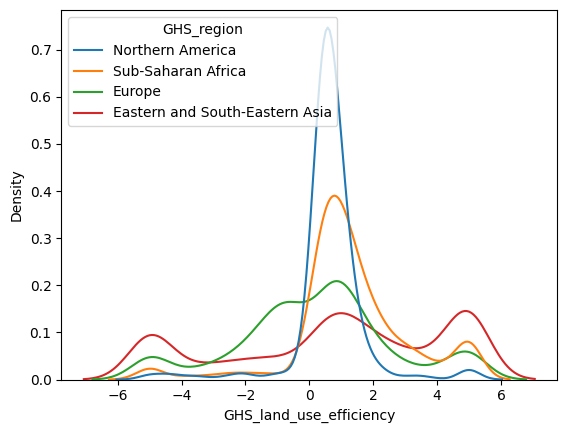

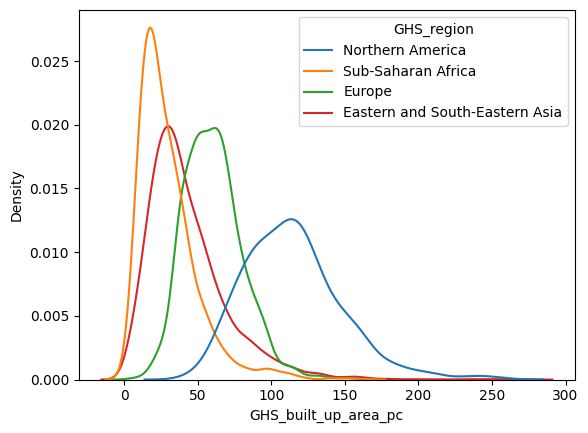

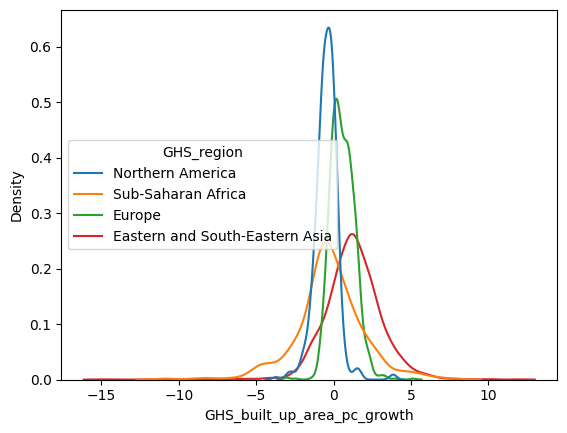

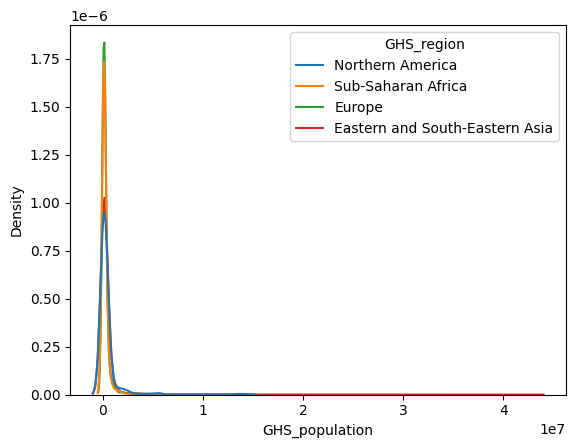

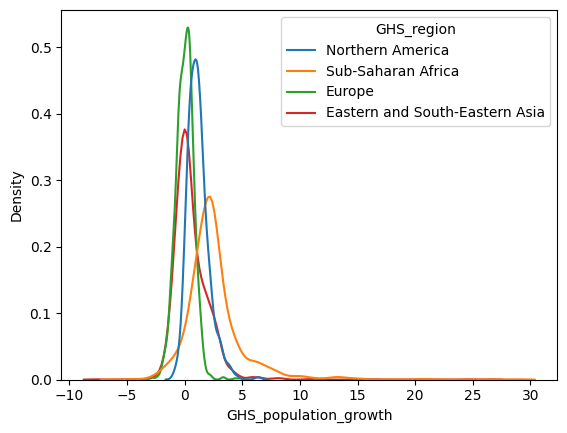

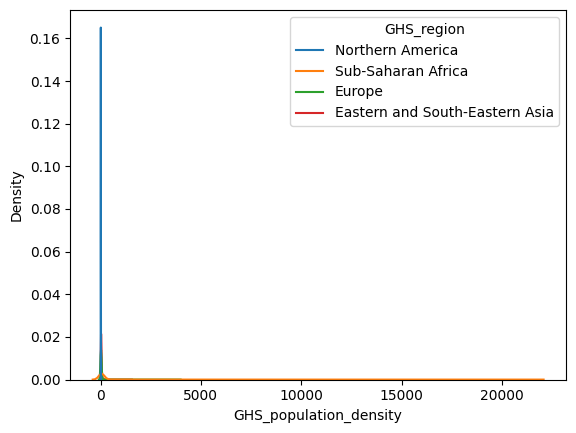

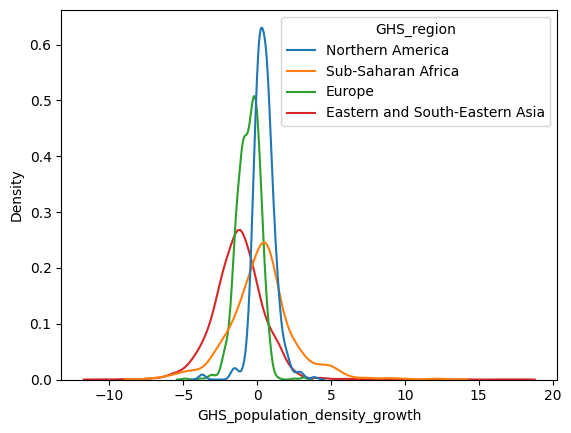

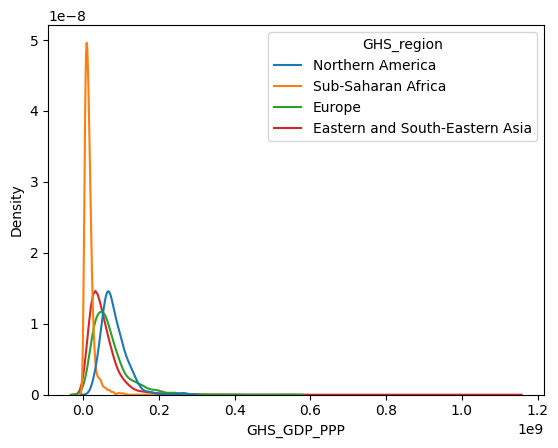

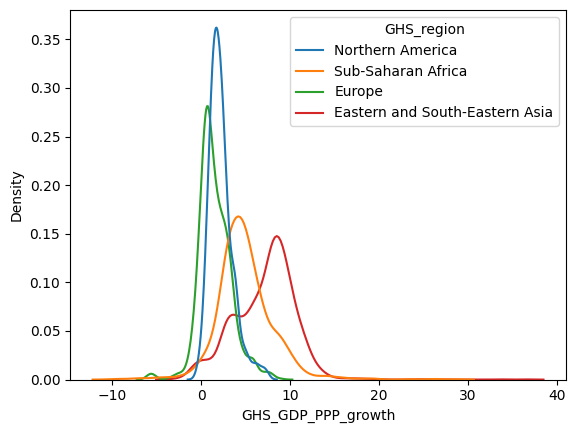

In [256]:
for v in ['GHS_land_use_efficiency', 'GHS_built_up_area_pc', 'GHS_built_up_area_pc_growth', 'GHS_population', 'GHS_population_growth', 'GHS_population_density', 'GHS_population_density_growth', 'GHS_GDP_PPP', 'GHS_GDP_PPP_growth']:
    # regions_of_interest = ['Oceania', 'Northern America', 'Latin America and the Caribbean', 'Sub-Saharan Africa', 'Europe', 'Northern Africa and Western Asia', 'Central and Southern Asia', 'Eastern and South-Eastern Asia', 'Australia and New Zealand']
    regions_of_interest = ['Northern America', 'Sub-Saharan Africa', 'Europe', 'Eastern and South-Eastern Asia']
    urban_areas_of_interest = urban_areas_2024[urban_areas_2024['GHS_region'].isin(regions_of_interest)]
    sns.kdeplot(urban_areas_of_interest, x=v, hue='GHS_region', common_norm=False)
    plt.show()

    

## Changes 2019-2024

In [131]:
city_locations_2019 = urban_areas_2019[['GHS_urban_area_id', 'geometry']]
city_locations_2019['geometry'] = city_locations_2019.to_crs(urban_areas_2024.crs).centroid

city_locations_2024 = urban_areas_2024[['GHS_urban_area_id', 'geometry']]
city_locations_2024['geometry'] = city_locations_2024.centroid

idx_2024, idx_2019 = city_locations_2019.sindex.nearest(city_locations_2024.geometry, max_distance=10000)

vals_2019 = urban_areas_2019.iloc[idx_2019][vars_to_plot].reset_index(drop=True)
vals_2024 = urban_areas_2024.iloc[idx_2024][vars_to_plot].reset_index(drop=True)

perc_changes = ((vals_2024 - vals_2019) / vals_2019).replace(-np.inf, np.nan).replace(np.inf, np.nan)


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [132]:
new_cities = urban_areas_2024.drop(urban_areas_2024.index[idx_2024])
dropped_cities = urban_areas_2019.drop(urban_areas_2019.index[idx_2019])

urban_areas_2024['new_city'] = True
urban_areas_2024.loc[urban_areas_2024.index[idx_2024], 'new_city'] = False

urban_areas_2019['dropped_city'] = True
urban_areas_2019.loc[urban_areas_2019.index[idx_2019], 'dropped_city'] = False



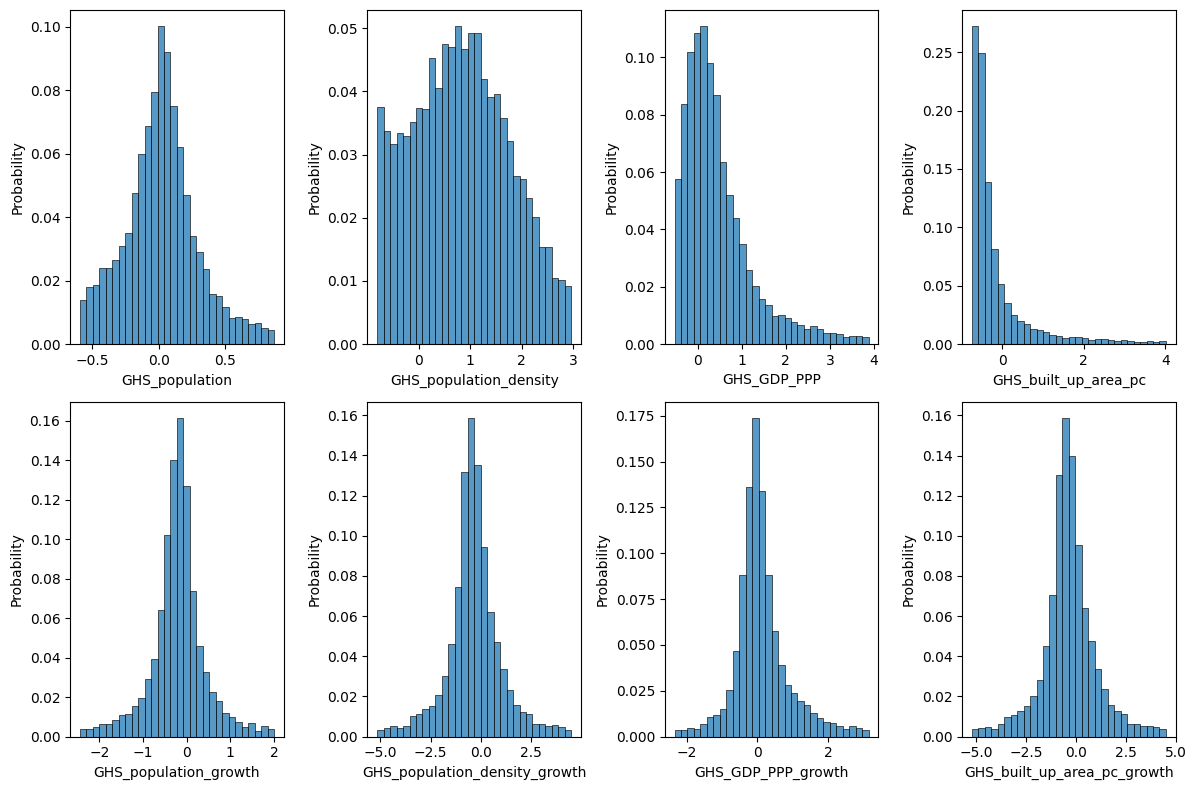

In [133]:
n_cols = 4
n_rows = -(-len(vars_to_plot) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()


perc_changes.abs().mean()
for ax, var in zip(axes, vars_to_plot):
    x = perc_changes[var].dropna()
    lower, upper = np.percentile(x, [5, 95])
    bin_edges = np.histogram_bin_edges(x, bins=30, range=(lower, upper))
    sns.histplot(perc_changes, x=var, stat="probability", bins=bin_edges, ax=ax)

# Hide unused subplots if any
for j in range(len(vars_to_plot), len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()


### Dropped cities

In [116]:
(dropped_cities['GHS_region'].value_counts() / urban_areas_2019['GHS_region'].value_counts()).round(2).sort_values(ascending=False).rename('Share of cities dropped per region')

Oceania                            0.48
Africa                             0.37
Asia                               0.30
Northern America                   0.26
Latin America and the Caribbean    0.10
Europe                             0.07
Name: Share of cities dropped per region, dtype: float64

In [117]:
(new_cities['continent'].value_counts() / urban_areas_2024['continent'].value_counts()).round(2).sort_values(ascending=False).rename('Share of new cities per region')

Australia        0.26
Oceania          0.22
North America    0.19
Africa           0.14
Asia             0.14
Europe           0.12
South America    0.08
Name: Share of new cities per region, dtype: float64

In [157]:
dropped_cities[vars_to_plot].describe()

,GHS_population,GHS_population_density,GHS_GDP_PPP,GHS_built_up_area_pc,GHS_population_growth,GHS_population_density_growth,GHS_GDP_PPP_growth,GHS_built_up_area_pc_growth
count,3.709000e+03,3.709000e+03,3709.000000,3709.000000,3709.000000,3684.000000,3468.000000,3684.000000
mean,1.117325e+05,inf,3591.596525,35.609890,inf,-2.768664,inf,inf
std,4.974030e+05,NaN,7055.370102,99.038550,NaN,14.397458,NaN,NaN
min,5.000246e+04,9.738869e+02,0.000000,0.000000,-12.935185,-100.000000,-100.000000,-34.566022
25%,5.791090e+04,4.737511e+04,337.597799,1.518821,0.426737,-2.045710,1.425546,-0.778973
50%,7.022862e+04,1.694579e+05,1496.470425,5.901170,1.445462,-0.441046,4.119632,0.443000
75%,9.614121e+04,6.584056e+05,3739.710124,21.108131,2.485685,0.785088,6.873196,2.088433
max,2.394235e+07,inf,158953.832439,1026.813236,inf,52.825798,inf,inf


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


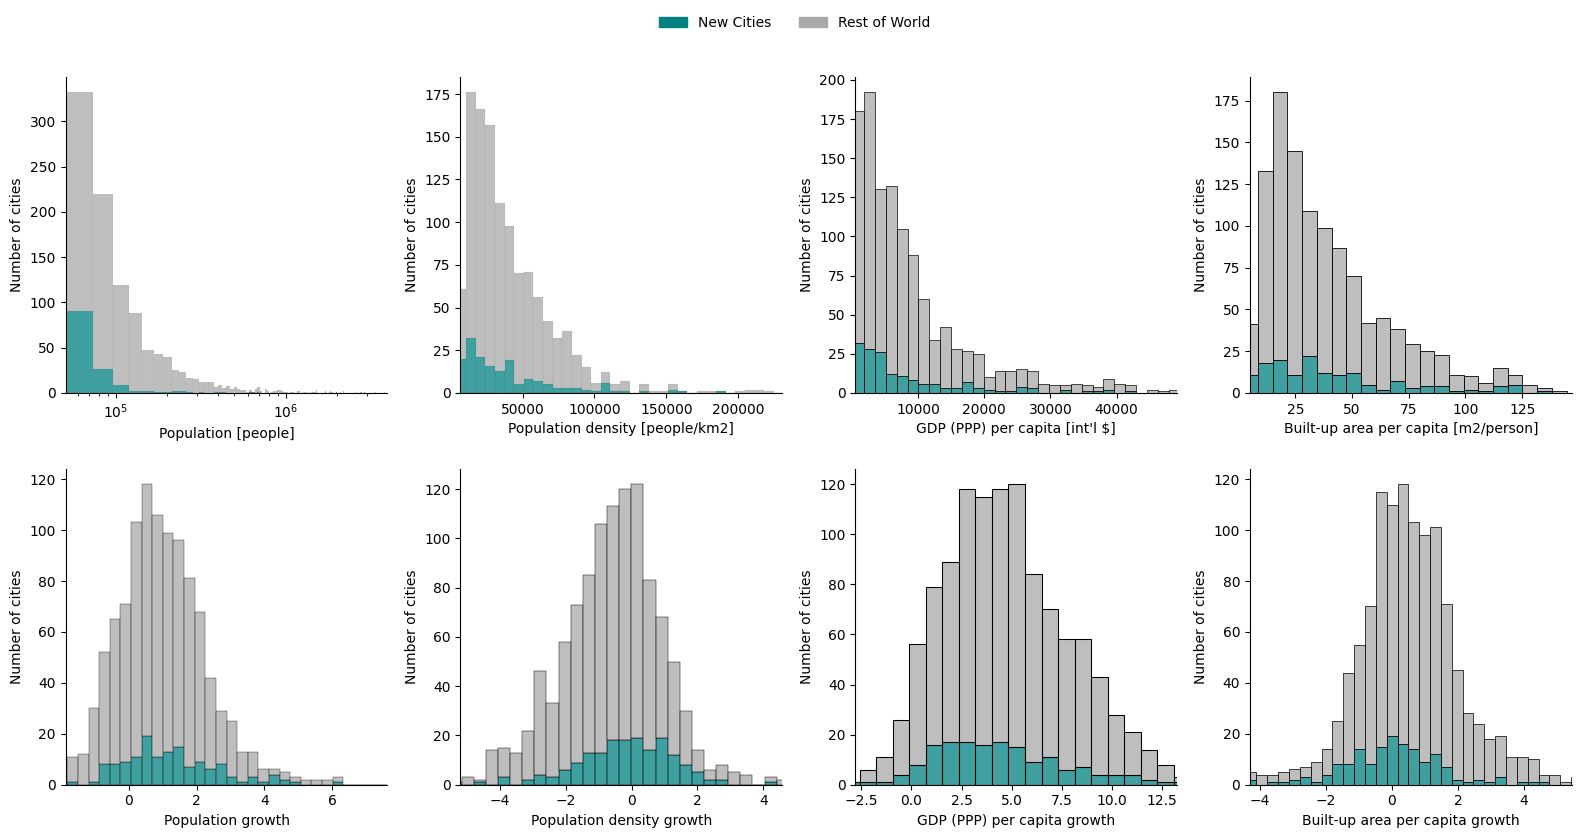

In [150]:

vars_to_plot = ['GHS_population', 'GHS_population_density', 'GHS_GDP_PPP', 'GHS_built_up_area_pc', 'GHS_population_growth', 'GHS_population_density_growth', 'GHS_GDP_PPP_growth', 'GHS_built_up_area_pc_growth']
df_long = pd.melt(urban_areas_2024, id_vars=['GHS_urban_area_id', 'new_city'], value_vars=vars_to_plot)
cat_type = CategoricalDtype(categories=vars_to_plot, ordered=True)
df_long['variable'] = df_long['variable'].astype(cat_type)


colors = ['darkgrey', 'teal']
for region_col in ['new_city']:
    g = sns.FacetGrid(df_long.sample(frac=0.1).sort_values(['variable', region_col], ascending=[True, True]), col="variable", sharex=False, sharey=False, col_wrap=4, height=4)
    g.map_dataframe(sns.histplot, "value", hue=region_col, hue_order=[False, True], palette=colors, multiple='stack')

    for ax, (var, subdata) in zip(g.axes.flat, df_long.groupby("variable")):
        ax.set_title("")
        ax.set_xlabel(var_labels[var])
        ax.set_ylabel('Number of cities')
        p5, p95 = np.percentile(subdata["value"].replace(np.inf, np.nan).dropna(), [1, 99])
        ax.set_xlim(p5, p95)
        if var == "GHS_population":
            ax.set_xscale("log")


    # Create custom legend
    patches = [ mpatches.Patch(color=colors[1], label='New Cities'), mpatches.Patch(color=colors[0], label='Rest of World')]
    g.fig.legend(
        handles=patches,
        title="",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        frameon=False
    )

    plt.show()


In [ ]:
dropped_cities['area [km2]'] = dropped_cities.to_crs(new_cities.crs).area / 1e6
dropped_cities.sort_values('GHS_population_density', ascending=False)[ ['GHS_urban_area', 'area [km2]'] + vars_of_interest].head(20)

,GHS_urban_area,area [km2],GHS_population,GHS_population_density,GHS_GDP_PPP,GHS_built_up_area_pc,GHS_population_growth,GHS_population_density_growth,GHS_GDP_PPP_growth,GHS_built_up_area_pc_growth
5340,Jemili,14.0,52632.092529,inf,7050.696223,0.000000,0.157143,NaN,9.200308,NaN
1529,Tan-Tan,18.0,72890.122559,inf,3071.560866,0.000000,2.000619,NaN,0.900026,NaN
8215,N/A,1.0,170489.125000,2.316428e+08,0.000000,0.004317,51.485639,-100.000000,-100.000000,inf
4540,N/A,2.0,526809.445312,1.972330e+08,0.000000,0.005070,16.961925,16.961925,NaN,-14.502091
4519,N/A,2.0,331137.923828,1.834559e+08,0.000000,0.005451,16.961925,16.961925,NaN,-14.502091
4498,N/A,1.0,318770.531250,1.792860e+08,288.004012,0.005578,16.961925,16.961925,3.000126,-14.502091
6091,N/A,1.0,88704.828125,1.410252e+08,0.000000,0.007091,56.240820,-100.000000,NaN,inf
6102,N/A,1.0,88422.765625,1.410252e+08,0.000000,0.007091,56.076201,-100.000000,NaN,inf
5575,Barabir,1.0,113288.210938,1.337523e+08,0.000000,0.007477,56.079072,-100.000000,NaN,inf
5584,Al Murabba,1.0,219621.296875,1.337523e+08,0.000000,0.007477,63.121294,-100.000000,NaN,inf


### Others drafty plots

<Axes: ylabel='GHS_country'>

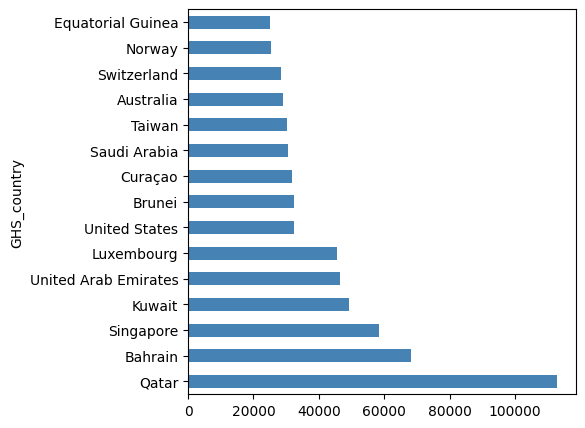

In [ ]:
# urban_areas_2019['GDP15_SM'].describe()
(urban_areas_2019['GHS_GDP_PPP']).groupby(urban_areas_2019['GHS_country']).mean().sort_values(ascending=False).head(15).plot(kind='barh', figsize=(5, 5), color='steelblue')

In [ ]:
urban_areas_2024['GHS_GDP_PPP'].describe()

count    1.142200e+04
mean     4.234021e+09
std      2.700284e+10
min      1.163323e+07
25%      2.876836e+08
50%      6.969205e+08
75%      1.912333e+09
max      1.089544e+12
Name: GHS_GDP_PPP, dtype: float64

<Axes: >

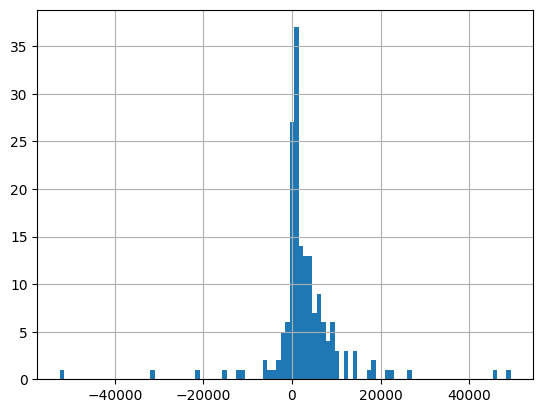

In [ ]:
((urban_areas_2024['GHS_GDP_PPP'] / urban_areas_2024['GHS_population']).groupby(urban_areas_2024['GHS_country']).mean() - (urban_areas_2019['GHS_GDP_PPP']).groupby(urban_areas_2019['GHS_country']).mean()).hist(bins=100)

<Axes: ylabel='GHS_country'>

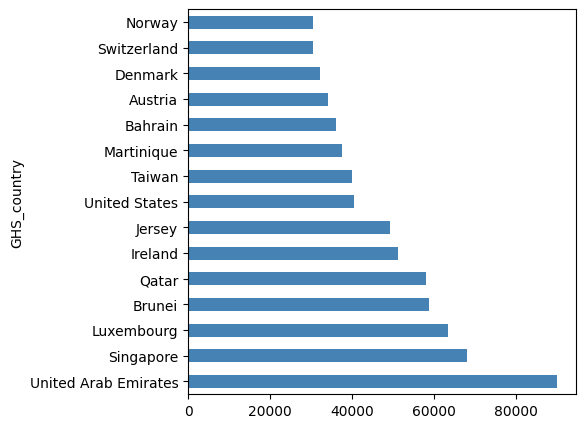

In [ ]:

# urban_areas_2024['GHS_GDP_PPP'].hist(bins=100)
(urban_areas_2024['GHS_GDP_PPP'] / urban_areas_2024['GHS_population']).groupby(urban_areas_2024['GHS_country']).median().sort_values(ascending=False).head(15).plot(kind='barh', figsize=(5, 5), color='steelblue')